Loading neccesary packages and prepping the Palmer Penquins data.

In [ ]:
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

np.set_printoptions(precision = 3)
plt.style.use('seaborn-v0_8-whitegrid')

url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
df = pd.read_csv(url)

# Shorten the species name
df["Species"] = df["Species"].str.split().str.get(0)

# filter our data so it only contains the variables we will look at first
# look at the first 5 entries to determine variables that seem as if they could have a correlation
df.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


In [34]:
df.groupby(["Island", "Species"]).size()

Island     Species  
Biscoe     Adelie       33
           Gentoo       98
Dream      Adelie       45
           Chinstrap    57
Torgersen  Adelie       42
dtype: int64

Torgersen Island is home exclusively to Adelie penguins, while Dream Island is the only habitat for Chinstrap penguins, despite an almost equal distribution of Adelie and Chinstrap there. Biscoe Island hosts primarily Gentoo penguins, making up 74.8% of its population. While Adelie penguins are found on all islands, each island has a degree of exclusivity in species distribution. This is a semi promising indicator. 

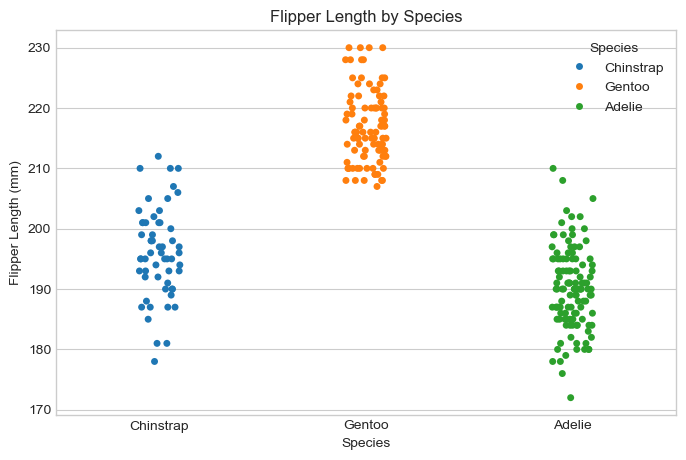

In [28]:
# explore the species groups by flipper length
plt.figure(figsize=(8, 5))
sns.stripplot(x = "Species", y = "Flipper Length (mm)", data = df, hue = "Species", legend = "brief")
plt.title("Flipper Length by Species")
plt.show()

Grouping by species and analyzing flipper length clearly distinguishes Gentoo penguins, as they generally have longer flippers than Chinstrap and Adelie penguins. However, flipper length is not a reliable identifier between Chinstrap and Adelie penguins, as their ranges overlap significantly.

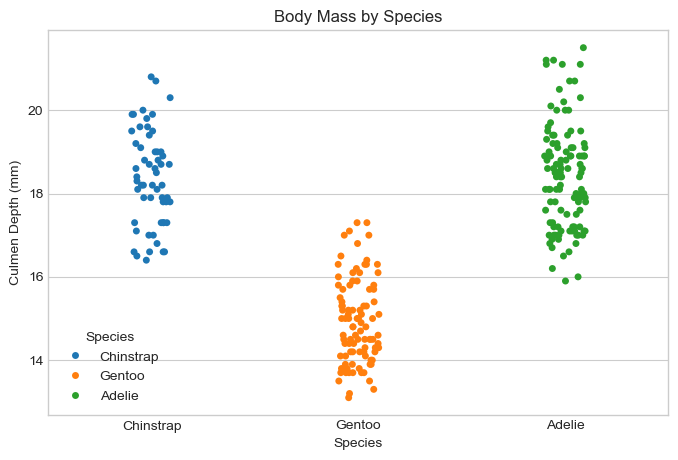

In [ ]:
# explore the species groups by body mass
plt.figure(figsize=(8, 5))
sns.stripplot(x = "Species", y = "Culmen Depth (mm)", data = df, hue = "Species", legend = "brief")
plt.title("Body Mass by Species")
plt.show()

Next we will define a method to properly give integer values to species as well as other categorical variables and apply this method to our data. 

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

x_train, y_train = prepare_data(df)